# An Analysis of Voting Polarization and Power

> “It’s not simply a handful of swing states that will decide the 2016 presidential election. The swing voters in the swing counties of the swing states will decide it. And if my calculations are correct, it is perhaps no more than 19 counties in 11 states…” - [David Schultz](https://www.minnpost.com/community-voices/2016/08/how-just-few-voters-few-us-counties-will-decide-presidential-election/)<sup>[1]</sup>

### Introduction
Every presidential election cycle we see statistics regarding turnout, regional political leaning, and the inequity of voting power.  Articles do discuss the changing voting patterns, although it's usually using maps and lists which can be hard for pattern comprehension.  The goal of this analysis is to help quantify voting polarization and power in a more easily interpretable form.  Below, are the three main research questions used to guide the analysis.

* _Research Question 1: Can we see voter polarization?_<br/>
That is, are red areas getting redder and are blue areas getting bluer. <br/>


* _Research Question 2: Is the proportion of people voting for third parties increasing?_<br/>
Are are larger proportion of voters trying to move away from the two-party political system? <br/>


* _Research Question 3: What is the weight of a vote?_<br/>
This is a way of looking to see if there is bias in the electoral college. That is, do red states typically have more power than blue states or vice versa. We already know there is any inequity of voting power from previous research and impact swing states have, so here we are really looking for a sysmatic bias in the power distubrution amoungst red and blue states. 

This sort of analysis is important for public understanding of the elections. Understanding bias, polarization, and inequity in our political system is important as the results of these elections have worldwide human implications.  Additionally, the inequity of voting power and polarization in our two-party political system both play a role in the disempowerment of voters. In 2016, only 55% of voting aged citizens voted in the Presidential elections.<sup>[2]</sup> One way to help empower votes, is to understand how and why voting habits are changing and how that is impacting voter turnout.  The more transparency the public has on political elections the more informed voters we can become.

### Background and Related Work
A 2013 Washington Post article discusses how red and blue mapping of the United States is misleading as most of America is mostly purple.<sup>[3]</sup> FiveThirtyEight responds to this with an article in 2017 claiming purple America is gone and few contested counties remain.<sup>[4]</sup> Only 303 counties were won with a single digit margin as compared to 1,096 in 1992.<sup>[4]</sup> FiveThirtyEight uses several maps to show the change over time. Recent research certainly indicates polarization should be visable at a county level, but for my analysis I avoid mapping as county size is not uniform and can negavatively impact the interpretability of the results. 

Historically, a majority of Americans have been in favor of a third major party, but the type is not agreed upon as some want a more liberal, more conservative, or more central party. Additionally, our electoral college winner takes all system all but ensures a two-party majority.  Third party candidtates are subjected to numerous systematic disadvantages including "a lack of federal matching funds, state ballot-access restrictions, and voters’ willingness to vote for the 'lesser of two evils.'"<sup>[5]</sup> Because of these systemmatic issues, it is unlikely outcomes change for the third party candidates. As a result I hypothesised, that if anything, there would be a small increase in people voting for third parties over time. 

An Observer article from 2016 looked into the power distribution amongst states.<sup>[6]</sup> Again, this source used maps and lists to convey the disribtuion of voting power.  Maps are helpful when looking for regional bias in the distribution but it makes it hard to see a systematic party power bias. Instead I will use a scatter plot. 

### Methods and Findings

#### Setup
First, we will import the packages necessary to run the following code.

In [1]:
import numpy as np
import pandas as pd
from pylab import figure
import matplotlib.pyplot as plt
from scipy.stats import linregress

#### County Popular Vote Data Import
The code in this section loads the county popular vote data from the 2000-2016 Presidential Elections. This [data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ) was retrieved from Harvard Dataverse and is licensed under [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/).

Here we:
* Load the data into a dataframe.
* Group all non republican and democratic candidates (third parties) into "other."
* Remove extra columns not necessary for the analysis.

In [2]:
# Load data into dataframe
county_vote_dataset = pd.read_csv('data/countypres_2000-2016.csv')

# Replace 'nan' and third party values with 'other"'
county_vote_dataset['party'].fillna('other', inplace = True)
county_vote_dataset.loc[(county_vote_dataset['party'] != 'republican') & 
                             (county_vote_dataset['party'] != 'democrat'), 'party'] = 'other'

# Fill 'nan' vote counts with 0
county_vote_dataset['candidatevotes'].fillna(0, inplace = True)
county_vote_dataset['totalvotes'].fillna(0, inplace = True)

# Drop unecessary columns
county_vote_dataset = county_vote_dataset.drop(columns = ['office', 'candidate', 'version'])

# View top few rows
county_vote_dataset.columns = ['year', 'state', 'state_po', 'county', 'FIPS', 'party', 'candidate_votes', 'total_votes']
county_vote_dataset.head()

,year,state,state_po,county,FIPS,party,candidate_votes,total_votes
0,2000,Alabama,AL,Autauga,1001.0,democrat,4942.0,17208.0
1,2000,Alabama,AL,Autauga,1001.0,republican,11993.0,17208.0
2,2000,Alabama,AL,Autauga,1001.0,other,160.0,17208.0
3,2000,Alabama,AL,Autauga,1001.0,other,113.0,17208.0
4,2000,Alabama,AL,Baldwin,1003.0,democrat,13997.0,56480.0


Here, we check that the bottom rows of the dataset look as expected.

In [3]:
# View bottom few rows
county_vote_dataset.tail(5)

,year,state,state_po,county,FIPS,party,candidate_votes,total_votes
50523,2016,Rhode Island,NaN,Federal Precinct,NaN,republican,53.0,0.0
50524,2016,Connecticut,NaN,Statewide writein,NaN,other,0.0,0.0
50525,2016,Maine,NaN,Maine UOCAVA,NaN,other,321.0,0.0
50526,2016,Alaska,NaN,District 99,NaN,other,28.0,0.0
50527,2016,Rhode Island,NaN,Federal Precinct,NaN,other,38.0,0.0


When we view the bottom rows of the dataset it becomes clear the dataset includes things beyond county votes like statewide writeins. In the next section, we remove anything without a FIPS code, a unqiue county identifier, to ensure we are just focused on county popular votes.

In [4]:
# Remove any rows with 'nan' FIPS values
county_votes_only = county_vote_dataset[(~np.isnan(county_vote_dataset['FIPS']))]

Previously, we grouped all non-republican and non-democratic candidates into "other" so below we recalculate the "candidate_votes" per party.

In [5]:
# Sum candidate votes across year, FIPS, and party
county_votes_only = county_votes_only.groupby(['year', 'state', 'state_po', 'county',
                                               'FIPS', 'party', 'total_votes']).sum()
county_votes_only = county_votes_only.reset_index()

In the dataset there is a "total_votes" column, which is suppose to be the total votes per county. I wanted to validate the number before using it in the rest of the analysis. The below code recalculates the total votes per county.

In [6]:
# Sum candidate votes over year and FIPS
validate_total = county_votes_only[['year', 'FIPS', 'candidate_votes']].groupby(['year', 'FIPS']).sum()
validate_total.columns = ['county_total']

Now we join our calculated total votes with the initial dataset for comparison. We see that 1047 records have a mismatch in the total votes count, so we drop the datasets total and use our calculation of the total in the remainder of the analysis.

In [7]:
# Join our total vote calculation with the imported dataset on year and FIPS
county_votes = county_votes_only.join(validate_total, how = 'left', on = ['year', 'FIPS'])

# Calculate the number of rows where our calculated total votes per county and year don't match the datasets'
corrected = county_votes[(county_votes['total_votes'] != county_votes['county_total'])]
print('Number of corrected totals:', len(corrected))

# Here we drop their 'total_votes' values and use the one we calculated
county_votes = county_votes.drop(columns = ['total_votes'])

Number of corrected totals: 1047


Next, we calculate the total number of republican (red) and democratic (blue) votes in order to later calculate a county "reddness" metric. "Redness" is measured as the average proportion of red voters (out of red or blue votes) in a county.
Then we join the total number of red and blue votes to our main county dataset.

In [8]:
# Sum votes for non-third party candidates
county_rb_votes = county_votes[(county_votes['party'] != 
                                'other')][['year', 'FIPS', 'candidate_votes']].groupby(['year', 'FIPS']).sum()
county_rb_votes.columns = ['redblue_total']

# Join to red/blue votes to county dataset
county_votes = county_votes.join(county_rb_votes, on = ['year', 'FIPS'], how = 'left')

county_votes.head(5)

,year,state,state_po,county,FIPS,party,candidate_votes,county_total,redblue_total
0,2000,Alabama,AL,Autauga,1001.0,democrat,4942.0,17208.0,16935.0
1,2000,Alabama,AL,Autauga,1001.0,other,273.0,17208.0,16935.0
2,2000,Alabama,AL,Autauga,1001.0,republican,11993.0,17208.0,16935.0
3,2000,Alabama,AL,Baldwin,1003.0,democrat,13997.0,56480.0,54869.0
4,2000,Alabama,AL,Baldwin,1003.0,other,1611.0,56480.0,54869.0


Next, we calculate:
1. Each party's propotion of the total votes in each county and year. 
2. Republican and Democratic portions of the "redblue_total," calculated in the last step, in each county and year.

In [9]:
# Party's proportion of total vote calculcation
county_votes['proportion_of_total'] = county_votes['candidate_votes'] / county_votes['county_total']

# Party's proportion of red/blue vote total calculcation. Set third party to 0.
county_votes['proportion_of_redblue'] = county_votes['candidate_votes'] / county_votes['redblue_total']
county_votes.loc[(county_votes['party'] == 'other'), 'proportion_of_redblue'] = 0

county_votes.head(5)

,year,state,state_po,county,FIPS,party,candidate_votes,county_total,redblue_total,proportion_of_total,proportion_of_redblue
0,2000,Alabama,AL,Autauga,1001.0,democrat,4942.0,17208.0,16935.0,0.287192,0.291822
1,2000,Alabama,AL,Autauga,1001.0,other,273.0,17208.0,16935.0,0.015865,0.000000
2,2000,Alabama,AL,Autauga,1001.0,republican,11993.0,17208.0,16935.0,0.696943,0.708178
3,2000,Alabama,AL,Baldwin,1003.0,democrat,13997.0,56480.0,54869.0,0.247822,0.255099
4,2000,Alabama,AL,Baldwin,1003.0,other,1611.0,56480.0,54869.0,0.028523,0.000000


Next, we calculate:
1. The average proportion of the total vote for each party and county over the last 5 elections.
2. The average proportion of the red/blue vote total for each party and county over the last 5 elections. This equals 0 for the third party.

In [10]:
county_summary = county_votes[['FIPS', 'party', 'proportion_of_total', 'proportion_of_redblue']]
county_summary = county_summary.groupby(['FIPS', 'party']).agg([np.mean, np.std])
county_summary.head(5)

proportion_of_total           proportion_of_redblue  \
                                 mean       std                  mean   
FIPS   party                                                            
1001.0 democrat              0.257088  0.021011              0.260764   
       other                 0.014180  0.012111              0.000000   
       republican            0.728733  0.021547              0.739236   
1003.0 democrat              0.224144  0.020870              0.228642   
       other                 0.019968  0.014049              0.000000   

                             
                        std  
FIPS   party                 
1001.0 democrat    0.020787  
       other       0.000000  
       republican  0.020787  
1003.0 democrat    0.020330  
       other       0.000000

Here we separate the average proportion of each party's vote in each county, and plot the distribution of each. Each county is represented in each party.  The sum of each county's average proportion of republican, democrat, and third party votes should sum to 1.

Number of counties with > 10% of votes to third party: 5
Max third party votes: 11.021818458800011 %
Total counties:  3154


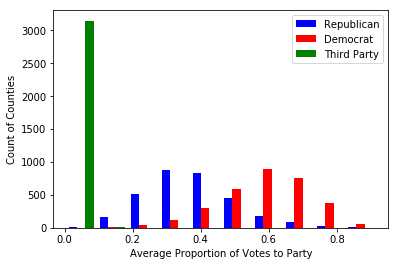

In [11]:
fig = plt.figure()
counties = county_summary.reset_index()

# Separate republican, democratic, and third party means.
blue_total = counties[(counties['party'] == 'democrat')]['proportion_of_total']['mean']
blue_rb = counties[(counties['party'] == 'democrat')]['proportion_of_redblue']['mean']

red_total = counties[(counties['party'] == 'republican')]['proportion_of_total']['mean']
red_rb = counties[(counties['party'] == 'republican')]['proportion_of_redblue']['mean']

other_total = counties[(counties['party'] == 'other')]['proportion_of_total']['mean']
other_total.fillna(0, inplace = True)

# Plot histogram of distributions
plt.hist([blue_total, red_total, other_total], color = ['blue', 'red', 'green'])
plt.ylabel("Count of Counties")
plt.xlabel("Average Proportion of Votes to Party")
plt.legend(["Republican", "Democrat", "Third Party"])

# Export image
fig.savefig('images/county_avg_party_proportions_distribution.png')

print("Number of counties with > 10% of votes to third party:", sum(other_total > .1))
print("Max third party votes:", max(other_total)*100, "%")
print("Total counties: ", len(other_total))

Above we see that in elections, the average proportion of third party votes in a county does not exceed 11.1%. Because of that they never win a county, so we will throw out these votes and focus on the proportion of red or blue votes out of the total number of red and blue votes in each county. 

Below, we plot the distribution of the proportion of red and blue voters in each country. Each county is plotted twice, once in the blue histogram and once in the red histogram. We see the red distribution mirrors the blue distribution because if you didn't vote red then you voted blue, since we threw our third party votes. The distribution shows that there are more red counties than blue, this is because there are more low-population, red, rural counties. 

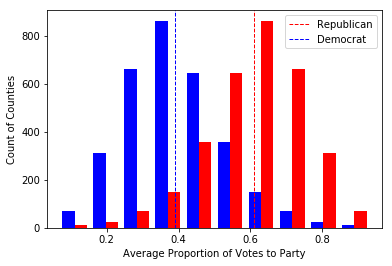

In [12]:
fig = plt.figure()

# Plot histogram of average proportion of red and blue votes in each county
plt.hist([blue_rb, red_rb], color = ['blue', 'red'])

# Plot the average of each distribution
plt.axvline(red_rb.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(blue_rb.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.ylabel("Count of Counties")
plt.xlabel("Average Proportion of Votes to Party")
plt.legend(["Republican", "Democrat"])

# Export image
fig.savefig('images/county_avg_red_blue_proportions_distribution.png')

Moving forward, we will just use the average proportion of red votes in each county over the last 5 elections. Truly red counties will be counties with a proportion greater than 0.5, and blue counties will be counties with a proportion less than 0.5. This will be referred to as a counties average "redness."

##### Research Question 1:
Now that we've calculated each counties average redness we want to measure whether red counties are becoming redder and blue counties are becoming bluer. We will do this is two way.

###### Method 1:
The first method, below, fits a linear regression to all 3154 counties' portion of red voters and election year. The slope of each county is plotted against the counties average 5-election redness. 

In [13]:
unique_counties = np.unique(county_votes['FIPS'])

success = []
slopes = []

# Loop over counties
for i in range(0, len(unique_counties)):    
    party = 'republican'
    proportions = county_votes[(county_votes['FIPS'] == unique_counties[i]) & (county_votes['party'] == party)]
    x = list(proportions['year'])
    y = list(proportions['proportion_of_redblue'])
    
    # Perform a linear regression on each county and save the slope and county's 5-election average redness
    try:
        lr = linregress(x, y)
    except ValueError:
        pass
    else:
        success.append(np.average(y))
        slopes.append(lr[0])

d = {'slopes': slopes, 'redness': success}
df = pd.DataFrame(data=d)

C:\Users\mstark\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\mstark\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\mstark\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Here we remove counties where the linear regression returned a 'nan' value for the slope.

In [14]:
df = df[(~np.isnan(df['slopes']))]
print("Number of counties removed:", len(unique_counties) - len(df))

Number of counties removed: 3


Next, we plot the slopes against each county's average redness. Then we fit linear regression, to the slopes of each counties' best fit line and their average redness, and look at the pearson correlation coefficient of the fit.

Correlation:  0.40676490249713665


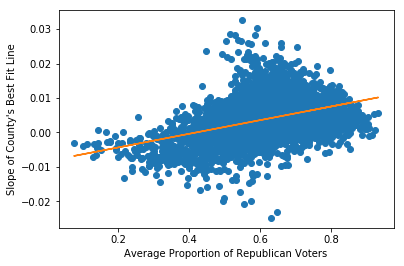

In [15]:
fig = plt.figure()

# Fit line to data
slope, intercept, r_value, p_value, std_err = linregress(df['redness'], df['slopes'])
print("Correlation: ", np.corrcoef(df['redness'], df['slopes'])[0][1])
line = slope * df['redness'] + intercept

# Plot redness vs. best fit slopes
plt.plot(df['redness'], df['slopes'],'o', df['redness'], line)
plt.ylabel("Slope of County's Best Fit Line")
plt.xlabel('Average Proportion of Republican Voters')

# Export image
fig.savefig('images/polarization_method_1.png')

Above we see a moderate, positive correlation between county slope and average redness. What this indicates is that red counties (where average redness is > 0.5) are correlated with positive slopes. In other words, red areas are getting redder.  Additionally be see non-red counties (blue counties) are correlated with negative slopes. In other words, non-red areas are getting less red or blue areas are getting bluer.

###### Method 2:
The second method, below, calculates the average proportion of red votes in red counties and the average proportion of blue votes in blue counties for each election year. Next, we plot a linear regression to each and look at the correlation. Red counties will be considered all counties with a proportion of red voters > 0.5 in any given election year. Blue counties will be considered all counties with a proportion of blue voters > 0.5 in any given election year.  Year to year swing counties will move between being considered a blue and red counties. This is okay as if there is a real change change in county level polarization swing areas will have a minimal effect. 

Red Counties:
P-value = 0.04719767487052674
Correlation Coefficient = 0.8829853721924514
Blue Counties:
P-value = 0.004121871778152564
Correlation = 0.9771877457483805


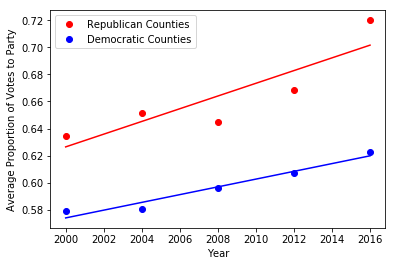

In [16]:
# Gets party and year values to iterate over and creates an empty array to store results in
years = np.unique(county_votes['year'])
parties = list(np.unique(county_votes.loc[county_votes['party'] != 'other', 'party']))
means = np.zeros((len(parties), len(years)))

# Iterates over election years and parties and calculates the mean proportion of votes for each party.
for i in range(0, len(years)):
    for j in range(0, len(parties)):
        sub = county_votes[(county_votes['year'] == years[i]) & (county_votes['party'] == parties[j])]
        means[j, i] = (sub.loc[(sub['proportion_of_redblue'] > 0.5), 'proportion_of_redblue']).mean()
        
fig = plt.figure()

# Fit linear regression to red counties
mean_r = means[parties.index('republican')]
slope, intercept, r_value, p_value, std_err = linregress(years, mean_r)
print('Red Counties:')
print('P-value =', p_value)
print('Correlation Coefficient =', np.corrcoef(years, mean_r)[0][1])
line_r = slope * years + intercept

# Fit linear regression to blue counties
mean_d = means[parties.index('democrat')]
slope_d, intercept_d, r_value_d, p_value_d, std_err_d = linregress(years, mean_d)
print('Blue Counties:')
print('P-value =', p_value_d)
print('Correlation =', np.corrcoef(years, mean_d)[0][1])
line_d = slope_d * years + intercept_d

# Plot
plt.plot(years, mean_r,'o', c = 'red')
plt.plot(years, mean_d,'o', years, line_d, c = 'blue')
plt.plot(years, line_r, c = 'red')
plt.ylabel('Average Proportion of Votes to Party')
plt.xlabel('Year')
plt.legend(['Republican Counties', 'Democratic Counties'])

# Export image
fig.savefig('images/polarization_method_2.png')

In the above plot we see both the average redness and blueness of red and blue counties, respectively, are increasing. Both yield a significant p-value from the linear regression (p < 0.05) and a strong positive correlation.  This indicates that blue and red counties are both winning by a larger average margin with each preceding election (i.e. counties are polarizing). We see there is more variability in the red fit, however red counties tend to have lower populations so their proportion of votes is much easier to change than high population blue counties. 

##### Research Question 2:
Now, we will reference back to our intitial county dataset and use it to calculate party vote portions of the total vote as now we also want to include non-county related voting like mailins.

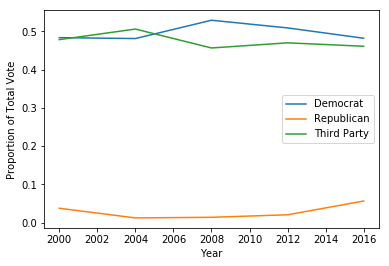

In [17]:
# Sum candidate votes over party and year to get votes per party and year
total_voters_per_party = county_vote_dataset[['year', 'party', 'candidate_votes']].groupby(['year', 'party']).sum()
total_voters_per_party.columns = ['votes_per_party']

# Sum votes per party and year over year to get votes per year
total_voters = total_voters_per_party.groupby(['year']).sum()
total_voters.columns = ['total_votes']

# Join above 2 dataframes on year
total_voters = total_voters_per_party.join(total_voters, how = 'left')

# Calculate party vote proportion of total
total_voters['proportion'] = total_voters['votes_per_party'] / total_voters['total_votes']

# Pivot joined dataframe to easily plot
total_voters = total_voters.reset_index()
total_voters = total_voters[['year', 'party', 'proportion']].pivot(index = 'year',
                                                                   columns = 'party', values = 'proportion')
# Plot
plot_fig = total_voters.plot()
fig = plot_fig.get_figure()
plt.ylabel('Proportion of Total Vote')
plt.xlabel('Year')
plt.legend(['Democrat', 'Republican', 'Third Party'])

# Export image
fig.savefig('images/third_party_voting.png')

From the above plot we can't conclusively say how voting for third parties is changing. More data would be necessary to view a trend. Rather the above chart shows two peaks in third party voting, which is more a measure of dissatisfaction in the two main party candidates.

Bonus: We see democrats won the popular vote in 4 out of 5 elections, but won the electoral college election in 2 of the 5 elections which displays the inquity of voting power in America.

##### Research Question 3:
This [data](https://www.archives.gov/federal-register/electoral-college/votes/2000_2005.html#2016) was retrieved from the National Archives and Records Administration and is licensed under [Creative Commons CC0 1.0 Universal](https://creativecommons.org/publicdomain/zero/1.0/) license. The licensing is specified in their privacy sections, [here](https://www.archives.gov/global-pages/privacy.html). There was no downloadedable version of the html, so I copied the tables to excel and reduced the candidate to their party affliations. I compiled the final dataset and posted it to my repository for easy reproducibility.

Here we:
 * Import the state electoral vote dataset.
 * Sum electoral votes over each election to validate they total to 538, for both votes available and cast. 

In [18]:
# Import state elector data
electoral_dataset = pd.read_csv('data/electoralpres_2000-2016.csv')
electoral_dataset.fillna(0, inplace = True)
electoral_dataset['Cast'] = (electoral_dataset[list(electoral_dataset.columns)[-5:]]).sum(axis=1)
electoral_dataset = electoral_dataset.rename(columns = {'Election_Year':'year', 'State': 'state'})
electoral_dataset = electoral_dataset.set_index(['year', 'state'])

# Validate electors cast per election
electoral_validate = (electoral_dataset.reset_index())[['State_Electoral_Votes', 'Cast', 'year']].groupby(['year']).sum()
electoral_validate.head()[(county_vote_dataset['party'] != 'other')]

C:\Users\mstark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,State_Electoral_Votes,Cast
year,,
2000,538,537.0
2004,538,538.0
2008,538,538.0
2012,538,538.0
2016,538,538.0


Note: 538 electors are cast each election except in 2000 where only 2 of 3 Washington D.C.'s were cast. One elector refused to vote in protest to Washington D.C.'s underrepresentation in Congress. 

Next we:
* Using the initial county dataset to calculate the total votes per state in each election. Again we ignore third party votes, as they never win the majority and the electoral college predominantly operates on a winner take all system.
* Then we calculate the total red votes per state and a state's proportion of red voters. This is to again calculate an average redness, but this time at a state level.
* Calculate the power of each state in every election. Power = the number of electors available / the total number of votes cast = the number of electors per voter
* Calculate the people per elector in every elestion. The inverse of our power metric.
* Calculate the average power for each state across the 5 elections.
* Calculate the average redness, or average proportion of red voters, in each state across the 5 elections.
* Divide states into red and blue states, and calculate the average power of each group. Red states are states where their average redness is > 0.5, and blue have average redness < 0.5. 
* Create scatter plot of state power verse redness, and plot group averages.

Average Red Power =  5.847685037196162e-06 +/- 2.236702642517416e-06
Average Blue Power =  5.679542785821677e-06 +/- 2.4838484495445902e-06


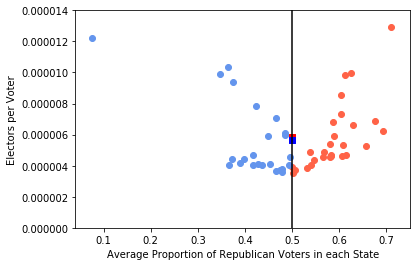

In [19]:
# Calculates total votes per state and election, removing third party votes as they are a low proportion of the total < 10%
state_votes = county_vote_dataset[['year', 'state', 'candidate_votes']][(county_vote_dataset['party']
                                                                         != 'other')].groupby(['year','state']).sum()
state_votes.columns = ['state_votes']

# Calculates total red votes per state and election
red_votes = county_vote_dataset[(county_vote_dataset['party'] == 
                                 'republican')][['year', 'state', 'candidate_votes']].groupby(['year','state']).sum()
red_votes.columns = ['red_votes']

# Calculates portion of red votes in each state and election
state_votes = state_votes.join(red_votes).reset_index()
state_votes['rb_proportion'] = state_votes['red_votes']/state_votes['state_votes']

# Joins electoral dataset with state vote proportions
electoral_popular = electoral_dataset.join(state_votes.set_index(['year', 'state']))

# Calculates the power of each state and the number of people per elector in each state
electoral_popular['power'] = electoral_popular['State_Electoral_Votes'] / electoral_popular['state_votes']
electoral_popular['ppl_per_elector'] = electoral_popular['state_votes'] / electoral_popular['State_Electoral_Votes']

# Calculates the average power of a state across the last 5 elections
power = (electoral_popular.reset_index())[[
    'state', 'power', 'State_Electoral_Votes']].groupby(['state']).agg([np.mean, np.std]).reset_index()
data = {'state': power['state'], 'avg_power': power['power']['mean']}
power = pd.DataFrame(data = data).set_index('state')
power.sort_values(['avg_power'])

# Calculates the average portion of red votes in each state over all 5 elections
state_votes_summary = state_votes[['state', 'rb_proportion']].groupby(['state']).agg([np.mean, np.std]).reset_index()

# Reformats the above dataframe to get rid of sub-dataframe created by the aggregration
data = {'state': state_votes_summary['state'], 'avg_redness': state_votes_summary['rb_proportion']['mean']}
state_df = pd.DataFrame(data = data)
state_df = state_df.set_index(['state'])

# Joins the power and redness dataframes 
power_and_redness = power.join(state_df, how = 'left').reset_index()

# Calculate avg_power across all red states
red_avg = power_and_redness[(power_and_redness['avg_redness'] > 0.5)]
ra = red_avg['avg_power'].mean()
rs = red_avg['avg_power'].std()
print('Average Red Power = ', ra, '+/-', rs)

# Calculate avg_power across all blue states
blue_avg = power_and_redness[(power_and_redness['avg_redness'] <= 0.5)]
ba = blue_avg['avg_power'].mean()
bs = blue_avg['avg_power'].std()
print('Average Blue Power = ', ba, '+/-', bs)

# Plot
fig = plt.figure()
plt.scatter('avg_redness', 'avg_power', data = red_avg, color = 'tomato')
plt.scatter('avg_redness', 'avg_power', data = blue_avg, color = 'cornflowerblue')
plt.scatter(0.5, ra, c = 'red', marker= "s")
plt.scatter(0.5, ba, c = 'blue', marker = "s")
plt.axvline(0.5, c = "black")
plt.ylabel('Electors per Voter')
plt.xlabel("Average Proportion of Republican Voters in each State")
plt.ylim([0,0.000014])

# Export image
fig.savefig('images/power_by_state_scatter.png', bbox_inches = "tight")

Above, we see a symmetry around 0.5. This is a significant marker as the electoral college predomantially opperates as winner takes all system. This means for states above the 0.5 average redness, the state electors would have gone to the republican candidate and states below would have gone to the democratic candidate. The symmetry doesn't really indicate a bias in the distribution of power. You can maybe say the baseline power of red states is slightly higher than blue states but the means of both groups are very similar, with red states having a slightly larger average power. The groups have overlapping error margins so we can't conclude that this is a statistically significant difference though.

Notes: In each party we see and outlier. The blue outlier is Washington D.C. and the red outlier is Wyoming which each have 3-4 times the average power of most states. 

Again this measure of power is a measure of the average number of electors per person in each state. However a state like California, which has 55 electors, is still more powerful than Washington D.C. which only have 3 electors. 

Below we look at swing states, the top ten states nearest to the 0.5 redness boundary.

In [20]:
# Calculate the 10 closes states to 0.5 average "Redness"
power_and_redness['swing'] = abs(power_and_redness['avg_redness'] - 0.5)
power_and_redness = power_and_redness.sort_values(['swing'])
power_and_redness.head(10)

,state,avg_power,avg_redness,swing
46,Virginia,0.000004,0.500623,0.000623
9,Florida,0.000004,0.502562,0.002562
15,Iowa,0.000005,0.494859,0.005141
5,Colorado,0.000004,0.493736,0.006264
35,Ohio,0.000004,0.506649,0.006649
28,Nevada,0.000006,0.484173,0.015827
29,New Hampshire,0.000006,0.484156,0.015844
49,Wisconsin,0.000004,0.479160,0.020840
38,Pennsylvania,0.000004,0.478996,0.021004
23,Minnesota,0.000004,0.473900,0.026100


Finally, I wanted to see how the power of each state compares when using the states population rather than the voter turnout.

Below we import the state 2016 estimated population dataset from the Census Bureau which operates on an open data policy, with more details available [here](https://www.census.gov/about/policies/open-gov/open-data.html).

In [21]:
# Import 2016 state population estimate by state data
state_population_dataset = pd.read_csv('data/nst-est2017-alldata.csv')
state_population_dataset = state_population_dataset[['NAME', 'POPESTIMATE2016']][(state_population_dataset['STATE'] != 0)]
state_population_dataset.columns = ['state', '2016_population']

Next:
* Find the number of electors in each state in 2016.
* Calculate state power in 2016 using states population.

In [22]:
# Finds each state's electoral college distribution by state
state_population_power = electoral_dataset.reset_index() 
state_population_power = state_population_power[(state_population_power['year'] == 
                                                 2016)][['state', 'State_Electoral_Votes']].set_index('state')

# Joins to state population dataset and calculates power
state_population_power = state_population_power.join(state_population_dataset.set_index('state'))
state_population_power['power'] = state_population_power['State_Electoral_Votes'] / state_population_power['2016_population']
state_population_power.head()

# Joins to state redness and power dataframe
state_power = state_population_power.join(state_df, how = "inner").join(power)
state_power.head()

,State_Electoral_Votes,2016_population,power,avg_redness,avg_power
state,,,,,
Alabama,9,4860545.0,0.000002,0.613929,0.000005
Alaska,3,741522.0,0.000004,0.613082,0.000010
Arizona,11,6908642.0,0.000002,0.538750,0.000005
Arkansas,6,2988231.0,0.000002,0.588824,0.000006
California,55,39296476.0,0.000001,0.396937,0.000004


Next, we generate a similar scatter plot of state average redness versus state power per resident.

Average Red Power =  2.2111090377565473e-06 +/- 9.430507012899785e-07
Average Blue Power =  2.2580727746127705e-06 +/- 9.647490307737943e-07


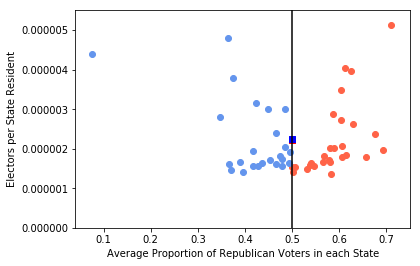

In [23]:
# Calculate avg_power across all red states
red_st_avg = state_power[(state_power['avg_redness'] > 0.5)]
ra_st = red_st_avg['power'].mean()
rs_st = red_st_avg['power'].std()
print('Average Red Power = ', ra_st, '+/-', rs_st)

# Calculate avg_power across all blue states
blue_st_avg = state_power[(state_power['avg_redness'] <= 0.5)]
ba_st = blue_st_avg['power'].mean()
bs_st = blue_st_avg['power'].std()
print('Average Blue Power = ', ba_st, '+/-', bs_st)

# Plot
fig = plt.figure()
plt.scatter('avg_redness', 'power', data = red_st_avg, color = 'tomato')
plt.scatter('avg_redness', 'power', data = blue_st_avg, color = 'cornflowerblue')
plt.scatter(0.5, ra_st, c = 'red', marker= "s")
plt.scatter(0.5, ba_st, c = 'blue', marker = "s")
plt.axvline(0.5, c = "black")
plt.ylim([0,0.0000055])
plt.ylabel('Electors per State Resident')
plt.xlabel("Average Proportion of Republican Voters in each State")

# Export image
fig.savefig('images/power_by_state_resident_scatter.png', bbox_inches = "tight")

Above, the results are very similar to before. We see the same general pattern and distribution. Which indicates power of states are uniformly effected by turnout.

Lastly we plot the power per voter vs. power per resident in each state.

Blue Counties:
P-value = 4.631572116881686e-26
Correlation = 0.9482406449767264


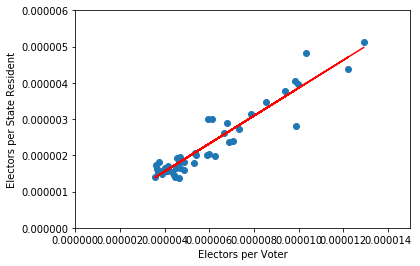

In [24]:
fig = plt.figure()
x = state_power['avg_power']
y = state_power['power']
plt.scatter(x, y)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('Blue Counties:')
print('P-value =', p_value)
print('Correlation =', np.corrcoef(x, y)[0][1])
line = slope * x + intercept
plt.plot(x, line, c = 'red')
plt.ylim([0, 0.000006])
plt.xlim([0, 0.000015])
plt.xlabel('Electors per Voter')
plt.ylabel('Electors per State Resident')

fig.savefig('images/state_vs_turnout_power.png',  bbox_inches = "tight")

The strong, positive, linear correlation between power per resident and power per voter again indicates that all states have about the same turnout.

### Discussion and Implications
A few limitations of the study were:
* The type of bias we were able to look for in the U.S. Presidential Election cycle.
* I only had access to actual voters cast, so it's hard to see how voter suppression plays into polarization and power.

Future work:
* We looked at county level polarization. With more time we could look at how that impacts state polarization, or if states are still fairly purple.
* Use more election data to see how the change in the last 5 election years compare to a longer time period. Are changes excellerating or growing linearly.

Implications:
* [Insert implications here].

### Conclusion
In summary I will restate my initial research questions and the results of each.

* _Question 1: Can we see a voter polarization? This is, are red areas becoming redder and vice versa._ 
<br>Yes, we were able to see both red and blue counties in american are polarizing and winning Presidential elections with high margins.<br/>
  
* _Question 2: Is the proportion of people voting for third parties increasing?_
<br>Simply, no. There is no conclusive pattern in the proportion of third party votes year over year. Rather the spikes indicate votes dissatisfaction in the main two-party candidates.<br/>

* _Question 3: What is there bias in the voting power distribution?_ 
<br>The symmetry of the distribution between red and blue states doesn't indicate a bias in the distribution of voter power. Though is just show the inequity of voting power amongst states.<br/>

More data and analysis is necessary to better answer questions 1 and 2. It's important to note that even though our conclusion to question 3 was that there wasn't a bias in the distribution of power amoungst red and blue states doesn't mean there is no bias in the electoral college as this was just one way of exploring potential bias. 

This analysis is a demonstration of human centered data science. Both the nature and implication of the analysis related to human interests. The plot and documentation choices were choosen to increase reproducibility, transparency, and interpretability for user.

### References
Any publications (blogs, articles, research papers) you refer to in the text.
1. https://www.minnpost.com/community-voices/2016/08/how-just-few-voters-few-us-counties-will-decide-presidential-election/
2. https://www.cnn.com/2016/11/11/politics/popular-vote-turnout-2016/index.html
3. https://www.washingtonpost.com/news/monkey-cage/wp/2013/11/12/most-americans-live-in-purple-america-not-red-or-blue-america/?utm_term=.5da51627fa8a
4. https://fivethirtyeight.com/features/purple-america-has-all-but-disappeared/
5. https://www.vox.com/polyarchy/2018/9/17/17870478/two-party-system-electoral-reform
6. https://www.washingtonpost.com/news/monkey-cage/wp/2016/11/15/5-things-you-need-to-know-about-how-third-party-candidates-did-in-2016/?utm_term=.c3db42d10280
7. https://observer.com/2016/11/the-built-in-bias-of-the-electoral-college/